In [11]:
import torch


device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
device

'cpu'

In [12]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm


train_dataset = CIFAR10(
	"data",
	True,
	ToTensor(),
	download=True,
)
test_dataset = CIFAR10(
	"data",
	False,
	ToTensor(),
	download=True,
)

len(train_dataset), len(test_dataset),len(train_dataset.classes)

(50000, 10000, 10)

In [13]:
from torch.utils.data import DataLoader

batch_size = 32
train_itr = DataLoader(
	dataset=train_dataset,
	batch_size=batch_size,
	shuffle=True,
)
test_itr = DataLoader(
	dataset=test_dataset,
	batch_size=batch_size,
	shuffle=True,
)
len(train_itr), len(test_itr)

(1563, 313)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)


class ResNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(ResNet, self).__init__()

        self.in_channels = 32
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layer1 = self._make_layer(32, 2, 1)
        self.layer2 = self._make_layer(64, 2, 2)
        self.layer3 = self._make_layer(128, 2, 2)
        self.layer4 = self._make_layer(256, 2, 2)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, start_dim=1)
        out = self.fc(out)
        return out

    def _make_layer(self, out_channels, blocks, stride):
        layers = [Block(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(Block(out_channels, out_channels))
        return nn.Sequential(*layers)


In [15]:
def accuracy(preds: torch.Tensor, real: torch.Tensor) -> float:
    return torch.eq(preds.argmax(dim=1), real).sum().item() / batch_size

In [16]:
mdl = ResNet(3,10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
	params=mdl.parameters(),
	lr=0.01,
)
mdl = mdl.to(device)

In [17]:
mdl.load_state_dict(state_dict=torch.load("saved_models/cifar10.pth", weights_only=True))

<All keys matched successfully>

In [18]:
epochs = 0

for epoch in range(epochs):
	mdl.train()
	for x, y in tqdm(train_itr):
		x, y = x.to(device), y.to(device)
		preds = mdl(x)
		loss = loss_fn(preds, y)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

	mdl.eval()
	with torch.inference_mode():
		tacc, tloss = 0.0, 0.0
		for tx, ty in tqdm(test_itr):
			tx, ty = tx.to(device), ty.to(device)
			tpreds = mdl(tx)
			tloss+=loss_fn(tpreds, ty)
			tacc+=accuracy(tpreds, ty)
		tacc/=len(test_itr)
		tloss/=len(test_itr)

	print(f"epoch:{epoch} acc:{tacc*100:.2f}% loss:{tloss:.2f}")

28/28 == 100.0%


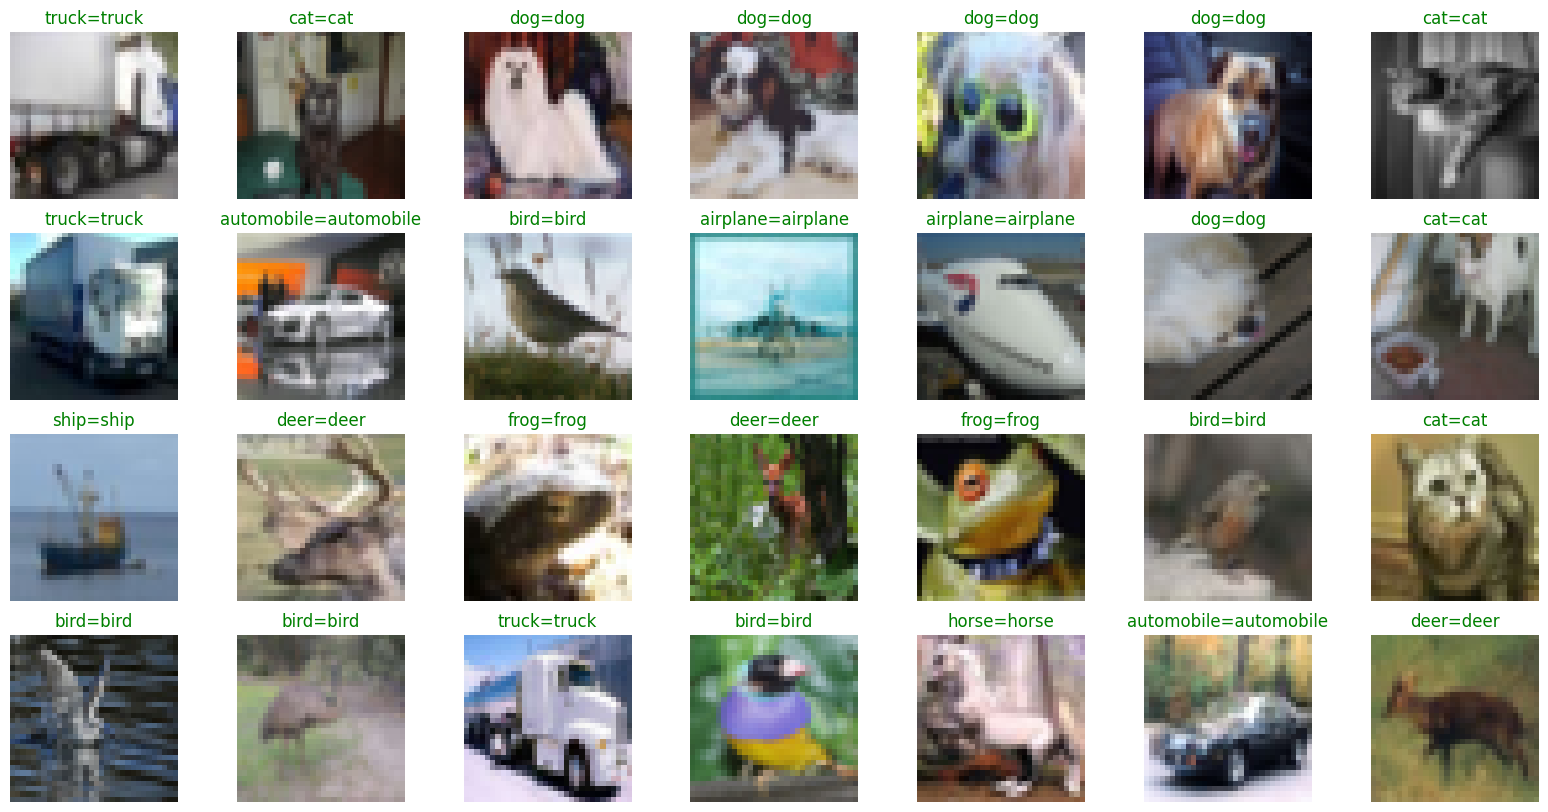

In [19]:
from matplotlib import pyplot as plt
from torch import randint
cnt = 0
fig = plt.figure(figsize=(20,10))
mdl.eval()
with torch.inference_mode():
	for i in range(28):
		img, label = train_dataset[randint(0, len(train_dataset), size=(1,)).item()]
		prediction = mdl(img.unsqueeze(0).to(device)).argmax(dim=1).item()
		# prediction = prediction.to(device)
		fig.add_subplot(4,7,i+1)
		plt.imshow(img.permute(1,2,0))
		if prediction == label: cnt+=1
		plt.title(f"{train_dataset.classes[label]}={train_dataset.classes[prediction]}", color="green" if prediction == label else "red")
		plt.axis(False)
print(f"{cnt}/28 == {cnt*100/28}%")

In [20]:
import os
os.makedirs("saved_models", exist_ok=True)
torch.save(mdl.state_dict(), "saved_models/cifar10.pth")